# Logistic Regression from Scratch

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import src.util as util
from src.linear_regression_model import  LinearModel

In [64]:
ds1_train_path = r'data/ds1_train.csv'
ds1_valid_path = r'data/ds1_valid.csv'

## Load Dataset

In [65]:
x_train, y_train = util.load_dataset(ds1_train_path, add_intercept=True) # Add 1 to the first input
x_valid, y_valid = util.load_dataset(ds1_valid_path, add_intercept=True)

Let's plot this dataset for visualization

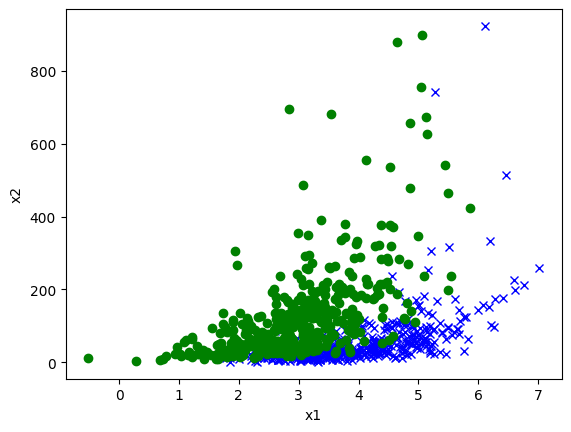

In [66]:
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(x_train[y_train == 1, -2], x_train[y_train == 1, -1], 'bx', linewidth=1)
plt.plot(x_train[y_train == 0, -2], x_train[y_train == 0, -1], 'go', linewidth=1)

## Maximize Log Likelihood
Recall the log likelihood function of Logistic Regression Model
$$
\begin{align*}
    \mathcal{l} (\theta) &= \displaystyle \sum_{i = 1}^m y^{(i)} \log h_{\theta} (x^{(i)} + (1 - y^{(i)}) \log (1 - h_{\theta} (x^{(i)})
\end{align*}
$$
We take derivitate respect to matrix $\theta$
$$
\begin{align*}
    \nabla_{\theta} \mathcal{l} (\theta) &= \nabla_{\theta} \displaystyle \sum_{i = 1}^m y^{(i)} \log h_{\theta} (x^{(i)} + (1 - y^{(i)}) \log (1 - h_{\theta} (x^{(i)}) \\
    &= \displaystyle \sum_{i = 1}^m \nabla_{\theta}  y^{(i)} \log h_{\theta} (x^{(i)} + (1 - y^{(i)}) \log (1 - h_{\theta} (x^{(i)}) \\
    &= \displaystyle \sum_{i = 1}^m y^{(i)} \frac{1}{g(\theta^T x^{(i)})} g(\theta^T x^{(i)}) (1 - g(\theta^T x^{(i)})) x^{(i)} + (1 - y^{(i)}) \frac{1}{1 - g(\theta^T x^{(i)})} (- g(\theta^T x^{(i)}) (1 - g(\theta^T x^{(i)}) )x^{(i)} \\
    &= \displaystyle \sum_{i = 1}^m (y^{(i)} - h_{\theta} (x^{(i)})) x^{(i)} \\
    &= K X^T, \text{ where $K$ is matrix $y - h$}
\end{align*}
$$
After we found the gradient respect to $\theta$. We want to find the Hessian matrix to apply Newton's method
$$
\begin{align*}
    H &= \nabla_{\theta^2} \mathcal{l} (\theta) \\
    &= \nabla_{\theta} \displaystyle \sum_{i = 1}^m (y^{(i)} - h_{\theta} (x^{(i)})) x^{(i)} \\
    &= \displaystyle \sum_{i = 1}^m \nabla_{\theta} (y^{(i)} - h_{\theta} (x^{(i)})) x^{(i)} \\
    &= - \displaystyle \sum_{i = 1}^m h_{\theta} (x^{(i)}) (1 - h_{\theta} (x^{(i)})) x^{(i)} {x^{(i)}}^T
\end{align*}
$$
After we found Hessian matrix, update $\theta$ follow:
$$
\begin{align*}
    \theta = \theta - H^{-1} \nabla_{\theta} \mathcal{l} (\theta)
\end{align*}
$$




## Implementation

In [67]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to maximize l(theta) for logistic regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))

        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of l(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,).
            """
            m, _ = x.shape
            return np.dot(x.T, (y - h(theta, x)))

        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """
            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))
            return - np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)

        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.

            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """
            return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros((n,))

        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)
        print('Train: ----------100%----------')
        self.theta = new_theta

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        return x @ self.theta >= 0

In [68]:
log_model = LogisticRegression()
log_model.fit(x_train, y_train)

Train: ----------100%----------


### Let's plot the hypothesis that we get after training and see how it work on training set and validation set

Accuracy: 0.8825


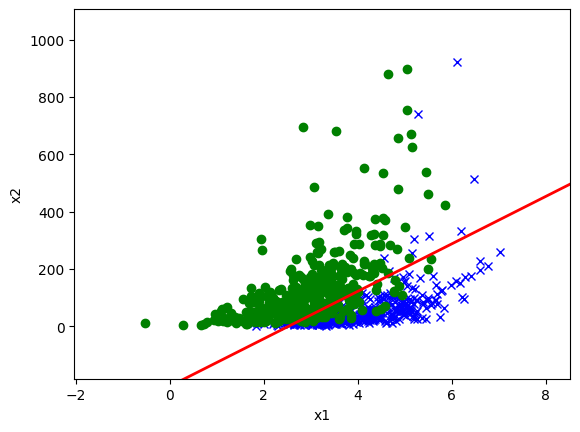

In [69]:
util.plot(x_train, y_train, theta=log_model.theta)
print(f'Accuracy: {np.mean(log_model.predict(x_train) == y_train)}')

Accuracy: 0.9


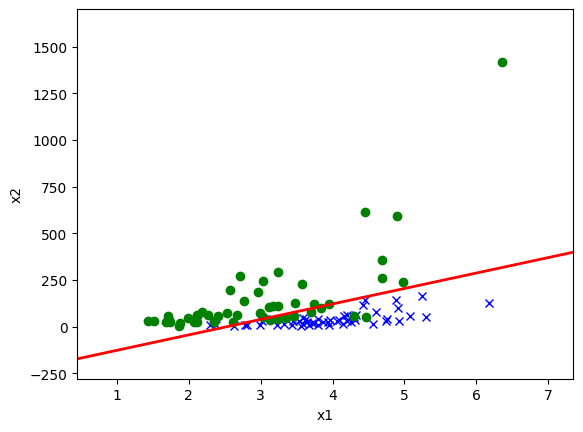

In [70]:
util.plot(x_valid, y_valid, theta=log_model.theta)
print(f'Accuracy: {np.mean(log_model.predict(x_valid) == y_valid)}')

In [75]:
class DrawLogisticRegression(LogisticRegression):
    def fit(self, x, y):
        """Run Newton's Method to maximize l(theta) for logistic regression.
    
        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """
        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).
    
            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))
    
        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of l(theta).
    
            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,).
            """
            m, _ = x.shape
            return np.dot(x.T, (y - h(theta, x)))
    
        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).
    
            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """
            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))
            return - np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)
    
        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.
    
            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """
            return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))
    
        m, n = x.shape
    
        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros((n,))
    
        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            util.plot(x_train, y_train, theta=old_theta)
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)
        print('Train: ----------100%----------')
        self.theta = new_theta

## A visualize how Logistic Regression convergence using Newton's method

Train: ----------100%----------


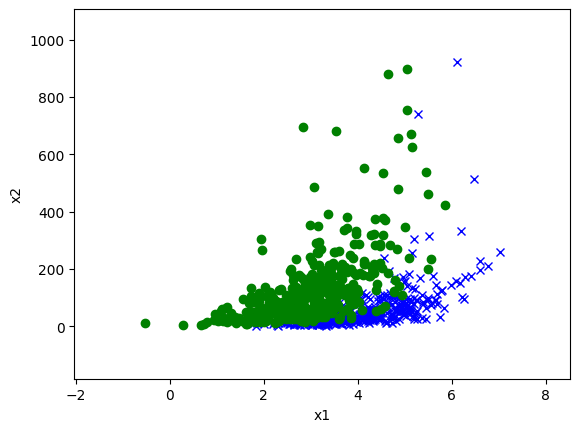

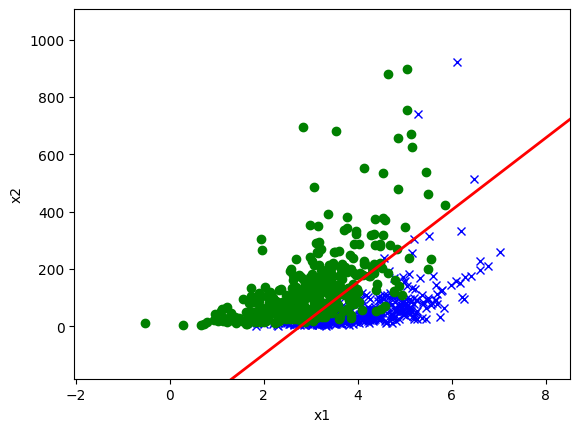

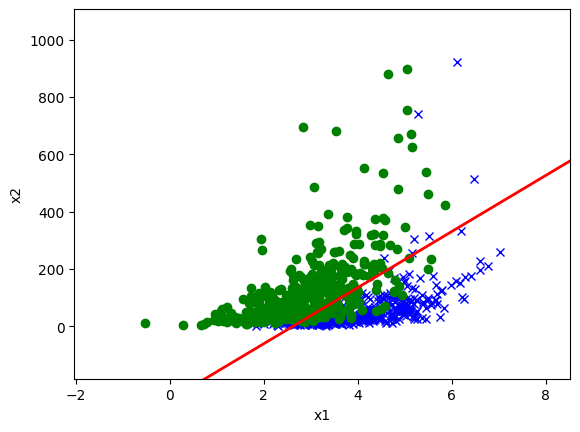

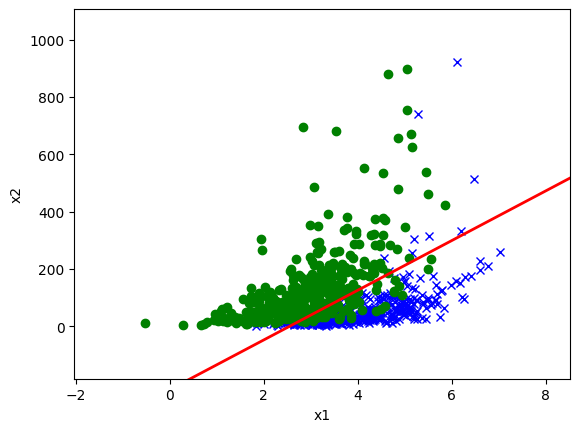

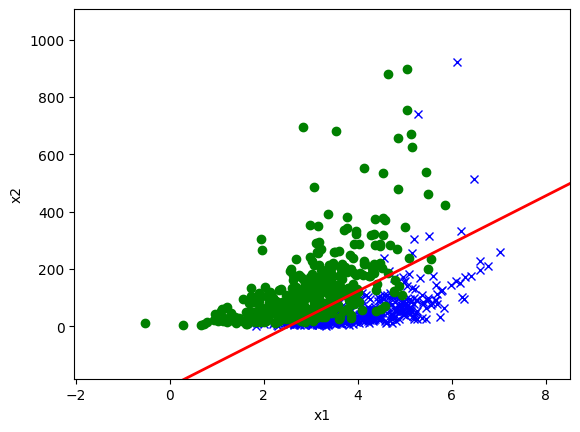

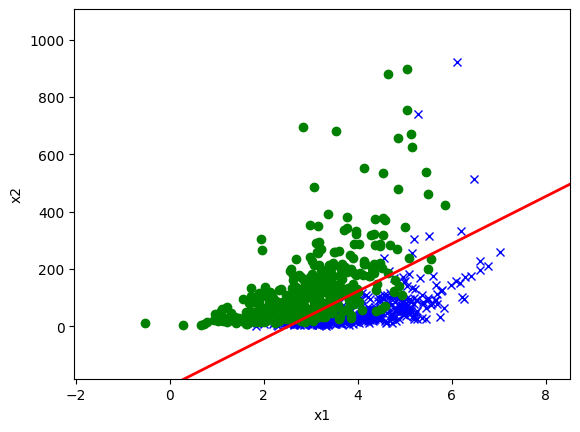

In [76]:
visualize_model = DrawLogisticRegression()
visualize_model.fit(x_train, y_train)

You can see that just 5 loop Newton's method is convergence. If we use Gradient Ascent to maximize log likelihood, it will take a lot of iteration to convergence. But this is a tradeoff, We want model to convergence spend less time, we have pay more computational cost